In [16]:
import torchvision.models as models
from writing_custom_datasets import CUB_200
import torch.utils.data
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
# import

In [17]:
def create_contrastive_dataloader(dataset,aug1,aug2,batch_size=32,shuffle=True,num_workers=0
):
    """
    Creates a DataLoader that returns pairs of differently augmented views of the same image.

    Args:
        dataset: Base dataset containing images
        aug1: First augmentation transform
        aug2: Second augmentation transform
        batch_size: Number of samples per batch
        shuffle: Whether to shuffle the data
        num_workers: Number of worker processes for data loading

    Returns:
        DataLoader that yields dictionaries containing:
            - 'aug1': First augmented view
            - 'aug2': Second augmented view
            - 'label': Original label
    """

    class ContrastiveDataset(Dataset):
        """
        Wrapper dataset that applies two different augmentations to each image
        for contrastive learning approaches.
        """

        def __init__(self, base_dataset, augmentation1, augmentation2):
            """
            Args:
                base_dataset: Original dataset containing images
                augmentation1: First augmentation transform
                augmentation2: Second augmentation transform
            """
            self.base_dataset = base_dataset
            self.aug1 = augmentation1
            self.aug2 = augmentation2

        def __getitem__(self, idx):
            image, label = self.base_dataset[idx]
            return {
                'aug1': self.aug1(image),
                'aug2': self.aug2(image),
                'label': label
            }

        def __len__(self):
            return len(self.base_dataset)

    contrastive_dataset = ContrastiveDataset(dataset, aug1, aug2)

    return DataLoader(
        contrastive_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )

def display_comparison_of_augmented_pairs(dataloader, num_pairs=3):
    """
    Display pairs of augmented images from the contrastive dataloader

    Args:
        dataloader: Contrastive dataloader returning aug1, aug2 pairs
        num_pairs: Number of image pairs to display
    """
    # Get a batch of data
    batch = next(iter(dataloader))
    aug1_images = batch['aug1']
    aug2_images = batch['aug2']
    labels = batch['label']

    # Create a figure with subplots for each pair
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 4 * num_pairs))
    fig.suptitle('Augmented Image Pairs from CUB-200 Dataset', fontsize=16)

    # Helper function to convert tensor to displayable image
    def tensor_to_img(tensor):
        # Remove batch dimension and move channels to last dimension
        img = tensor.permute(1, 2, 0)
        # Convert to numpy and clip to valid range
        img = img.numpy().clip(0, 1)
        return img

    for idx in range(num_pairs):
        # Display first augmentation
        axes[idx, 0].imshow(tensor_to_img(aug1_images[idx]))
        axes[idx, 0].set_title(f'Aug1 - Label: {labels[idx].item()}')
        axes[idx, 0].axis('off')

        # Display second augmentation
        axes[idx, 1].imshow(tensor_to_img(aug2_images[idx]))
        axes[idx, 1].set_title(f'Aug2 - Label: {labels[idx].item()}')
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

def inverse_transform(transformations):
    """
    Create an inverse of the given transformations for spatial or planar reversal.

    Args:
        transformations: List of torchvision transformations to reverse.

    Returns:
        torchvision.transforms.Compose object that reverses the given transformations.
    """
    reversed_transforms = []

    for transform in reversed(transformations.transforms):  # Reverse the order of transformations
        if isinstance(transform, transforms.Normalize):
            # To reverse Normalize, create an un-normalization transform
            mean = torch.tensor(transform.mean)
            std = torch.tensor(transform.std)
            reversed_transforms.append(transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist()))
        elif isinstance(transform, transforms.RandomHorizontalFlip):
            # Reverse Horizontal Flip by adding it again
            reversed_transforms.append(transforms.RandomHorizontalFlip(p=1.0))
        elif isinstance(transform, transforms.RandomVerticalFlip):
            # Reverse Vertical Flip by adding it again
            reversed_transforms.append(transforms.RandomVerticalFlip(p=1.0))
        elif isinstance(transform, transforms.ToTensor):
            # Tensor conversion can be seen as a no-op (no need for reversal)
            continue
        else:
            # Skip transformations that cannot be inverted
            continue

    # Return the reversed transformations as a Compose object
    return transforms.Compose(reversed_transforms)

def consistency_loss(Ft, Fs, invaug2, invaug1):
    """
    Consistency Loss: Measures the difference between augmented feature projections.

    Args:
        Ft: Feature projection from the teacher network
        Fs: Feature projection from the student network
        invaug2: Inverse augmentation applied to the teacher's feature map
        invaug1: Inverse augmentation applied to the student's feature map

    Returns:
        Consistency loss value
    """
    Ft_res = invaug2(Ft)  # Apply inverse augmentation to the teacher's output
    Fs_res = invaug1(Fs)  # Apply inverse augmentation to the student's output
    return torch.norm(Ft_res - Fs_res, p=2)  # L2 Loss


def main():
    aug1 = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
        transforms.ToTensor(),
    ])

    aug2 = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),  # 调整裁剪的范围，更大的裁剪变换
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.2),  # 扩大色调变化范围
        transforms.RandomRotation(30),  # 加入旋转
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # 平移变换，增大范围
        transforms.ToTensor(),
    ])

    dataloader = create_contrastive_dataloader(
        dataset=CUB_200(root='CUB-200', train=True, download=True),
        aug1=aug1,
        aug2=aug2,
        batch_size=32
    )

    # display_comparison_of_augmented_pairs(dataloader)

    batch = next(iter(dataloader))
    batch_transformed_images_1 = batch['aug1']
    batch_transformed_images_2 = batch['aug2']

    StudentNet = models.resnet18(pretrained=True)
    TeacherNet = models.resnet50(pretrained=True)

    StudentNet.fc = torch.nn.Linear(StudentNet.fc.in_features, 200)
    TeacherNet.fc = torch.nn.Linear(TeacherNet.fc.in_features, 200)

    Fs = StudentNet.fc
    Ft = TeacherNet.fc

    Ft_aligned = torch.nn.Conv2d(Fs.in_features, Ft.in_features,
                                 kernel_size=1, stride=1, padding=0, bias=False)

    invaug1 = inverse_transform(aug1)
    invaug2 = inverse_transform(aug2)

    print("Aug1 Parameters:")
    print(aug1.__dict__)

    print("\nAug2 Parameters:")
    print(aug2.__dict__)

    print("\nInverse Aug1 Parameters:")
    print(invaug1.__dict__)

    print("\nInverse Aug2 Parameters:")
    print(invaug2.__dict__)


In [18]:
    aug1 = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(20),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
        transforms.ToTensor(),
    ])

    aug2 = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),  # 调整裁剪的范围，更大的裁剪变换
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.2),  # 扩大色调变化范围
        transforms.RandomRotation(30),  # 加入旋转
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # 平移变换，增大范围
        transforms.ToTensor(),
    ])

    dataloader = create_contrastive_dataloader(
        dataset=CUB_200(root='CUB-200', train=True, download=True),
        aug1=aug1,
        aug2=aug2,
        batch_size=32
    )

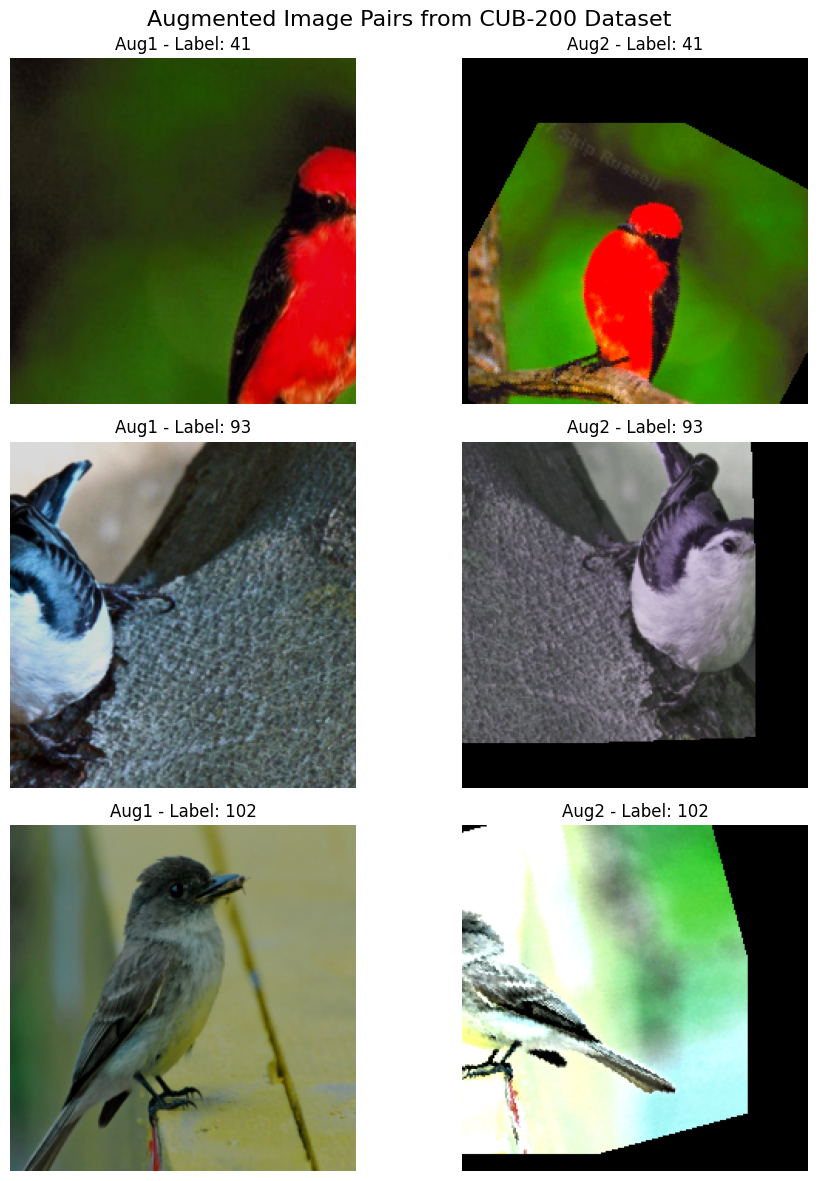

In [19]:

    display_comparison_of_augmented_pairs(dataloader)


2.4)  添加一个consistency loss: L= || invaug2(Ft) - invaug1(Fs) ||.

The consistency loss is defined as:

\[
L_{consistency} = || \text{invaug2}(F_t) - \text{invaug1}(F_s) ||
\]

    Fs = StudentNet.fc
    Ft = TeacherNet.fc

    Ft = torch.nn.Conv2d(Fs.in_features, Ft.in_features,
                                 kernel_size=1, stride=1, padding=0, bias=False)

    invaug1 = inverse_transform(aug1)
    invaug2 = inverse_transform(aug2)

loss =


其中，invaug1和invaug2进行数据增强中平面变换的逆变换，例如原本是向右平移，逆就是向左平移。2.5）对StudentNet额外有分类代价函数。对TeacherNet的参数进行冻结，不进行更新。2.6）设计可视化证明你的consistency loss没有施加错误，例如图片变换和特征逆变换都是位置对应的，平面变换没有错误。


In [21]:
batch = next(iter(dataloader))
batch_transformed_images_1 = batch['aug1']
batch_transformed_images_2 = batch['aug2']

StudentNet = models.resnet18(pretrained=True)
TeacherNet = models.resnet50(pretrained=True)

StudentNet.fc = torch.nn.Linear(StudentNet.fc.in_features, 200)
TeacherNet.fc = torch.nn.Linear(TeacherNet.fc.in_features, 200)

Fs = StudentNet.fc
Ft = TeacherNet.fc

Ft = torch.nn.Conv2d(Fs.in_features, Ft.in_features,
                             kernel_size=1, stride=1, padding=0, bias=False)

invaug1 = inverse_transform(aug1)
invaug2 = inverse_transform(aug2)

print("Aug1 Parameters:")
print(aug1.__dict__)

print("\nAug2 Parameters:")
print(aug2.__dict__)

print("\nInverse Aug1 Parameters:")
print(invaug1.__dict__)

print("\nInverse Aug2 Parameters:")
print(invaug2.__dict__)


Aug1 Parameters:
{'transforms': [RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True), RandomHorizontalFlip(p=20), ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.1, 0.1)), ToTensor()]}

Aug2 Parameters:
{'transforms': [RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True), RandomHorizontalFlip(p=0.5), ColorJitter(brightness=(0.4, 1.6), contrast=(0.4, 1.6), saturation=(0.4, 1.6), hue=(-0.2, 0.2)), RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0), RandomAffine(degrees=[0.0, 0.0], translate=(0.2, 0.2)), ToTensor()]}

Inverse Aug1 Parameters:
{'transforms': [RandomHorizontalFlip(p=1.0)]}

Inverse Aug2 Parameters:
{'transforms': [RandomHorizontalFlip(p=1.0)]}
